# Trabalho 1 - Machine Learning II 
Prof: Carlos Padilha

#### Alunos:  

Roberto A. Coutinho  
Thais Galho


## Sistemas com Multi-classificadores ou Ensembles

#### Este trabalho visa avaliar o entendimento em relaçãao á construção de sistemas com multi-classificadores ou ensembles. Para tal, os alunos deverão fazer o seguinte:


* Implementar o algoritmo AdaBoost (nos mesmos moldes que fizemos com o algoritmo Bagging).
    – Podem escolher qualquer tipo de classificador (MLP, SVM, etc).
* Processar os dados presente no arquivo sonar.all-data.
* Realizar treinamento e teste usando validação cruzada com 10 folds.
* Avaliar os resultados em termos de acurácia, recall e precisão.

Obs: O trabalho pode ser feito em dupla e deve ser enviado por email (carlos.engcomp@gmail.com).

# Imports

In [246]:
import numpy as np
import pandas as pd

# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# K-fold CrossValidation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Leitura do dataset
 - Importação do dataset
 - Categorização da coluna de label
 - Embaralhamento da dsitribuição do dataset
     - Obs: O dataset estava ordernado com a primeira classe nos primeiros 50% e a segunda classe nos outros 50%. 

In [234]:
# Import dos dados
imported_data = pd.read_csv('sonar.all-data.csv', header=None)

# Categorização
imported_data.iloc[:,-1] = imported_data.iloc[:,-1].astype('category')
categories = imported_data.select_dtypes(['category']).columns
imported_data[categories] = imported_data[categories].apply(lambda x:x.cat.codes) 

# reamostragem do dataset com fração de 10%
imported_data = imported_data.sample(frac=1).reset_index(drop=True)

imported_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0192,0.0607,0.0378,0.0774,0.1388,0.0809,0.0568,0.0219,0.1037,0.1186,...,0.0331,0.0131,0.0120,0.0108,0.0024,0.0045,0.0037,0.0112,0.0075,1
1,0.0109,0.0093,0.0121,0.0378,0.0679,0.0863,0.1004,0.0664,0.0941,0.1036,...,0.0077,0.0023,0.0117,0.0053,0.0077,0.0076,0.0056,0.0055,0.0039,1
2,0.0189,0.0308,0.0197,0.0622,0.0080,0.0789,0.1440,0.1451,0.1789,0.2522,...,0.0038,0.0096,0.0142,0.0190,0.0140,0.0099,0.0092,0.0052,0.0075,1
3,0.0094,0.0611,0.1136,0.1203,0.0403,0.1227,0.2495,0.4566,0.6587,0.5079,...,0.0234,0.0175,0.0352,0.0158,0.0326,0.0201,0.0168,0.0245,0.0154,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1
5,0.0428,0.0555,0.0708,0.0618,0.1215,0.1524,0.1543,0.0391,0.0610,0.0113,...,0.0142,0.0179,0.0079,0.0060,0.0131,0.0089,0.0084,0.0113,0.0049,0
6,0.0137,0.0297,0.0116,0.0082,0.0241,0.0253,0.0279,0.0130,0.0489,0.0874,...,0.0081,0.0040,0.0025,0.0036,0.0058,0.0067,0.0035,0.0043,0.0033,0
7,0.0378,0.0318,0.0423,0.0350,0.1787,0.1635,0.0887,0.0817,0.1779,0.2053,...,0.0046,0.0044,0.0078,0.0102,0.0065,0.0061,0.0062,0.0043,0.0053,1
8,0.0315,0.0252,0.0167,0.0479,0.0902,0.1057,0.1024,0.1209,0.1241,0.1533,...,0.0108,0.0062,0.0044,0.0072,0.0007,0.0054,0.0035,0.0001,0.0055,0
9,0.0299,0.0688,0.0992,0.1021,0.0800,0.0629,0.0130,0.0813,0.1761,0.0998,...,0.0459,0.0277,0.0172,0.0087,0.0046,0.0203,0.0130,0.0115,0.0015,0


### Definição de funções auxiliares

    - Definição da função para avaliar as diferentes métricas

In [128]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score

def printCM(Y_test, predictions):
    cm = confusion_matrix(Y_test, predictions)
    acc_score = accuracy_score(Y_test, predictions)
    prec_score = precision_score(Y_test, predictions, average='weighted')
    
    print ('Confusion Matrix : ')
    print (cm)
    print
    
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    actual_yes = fn+tp
    actual_no = tn+fp
    predicted_yes = fp+tp
    predicted_no = tn+fn

    total = float(len(imported_data))
    print ('Total : '+ str(total))

    print ('Acurácia : ' + str(acc_score))

    misclassification_rate = round((fp+fn)/total,3) # Overall, how often is it wrong?
    print ('Misclassification rate : ' +str(misclassification_rate))

    true_positive = round(tp/actual_yes,3) # When it's actually yes, how often does it predict yes?
    print ('True positives : ' +str(true_positive))

    false_positive = round(fp/actual_no,3) # When it's actually no, how often does it predict yes?
    print ('False positives : ' +str(false_positive))

    specificity = round(tn/actual_no,3) # When it's actually no, how often does it predict no?
    print ('Specificity : ' +str(specificity))

    #precision = round(tp/predicted_yes,3) # When it predicts yes, how often is it correct?
    print ('Precision : ' +str(prec_score))

    prevalence = round(actual_yes/total,3) # How often does the yes condition actually occur in our sample?
    print ('Prevalence : ' +str(prevalence))
    
    recall = round(tp / (tp + fn), 3)
    print ('Recall : ' +str(recall))

    #f1 = round(2 * ((precision * true_positive) / (precision + true_positive)),3)
    #print ('F1 Score : ' +str(f1))
    
    return acc_score, prec_score, recall

# Pré-processamento

    - Separação do dataset entre treinamento e labels na proporção de 80/20 por cento.

##### Separação entre treino e teste

In [236]:
labels = imported_data.iloc[:,-1]

data = imported_data.iloc[:,:-1]
len(data), len(labels)

# utiliza 25% do dataset para teste
trainData, validationData, trainLabels, validationLabels = train_test_split(data, labels, 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    stratify=labels,
                                                    random_state=43)

print(len(trainData), len(trainLabels))
print(len(validationData), len(validationLabels))

166 166
42 42


# AdaBoosting 

Na seção abaixo é realizado o treinamento do ensemble AdaBoosting

    - 10 KFolds 

In [225]:
scores = []
scores_test = []

error_train = []
error_test = []

n_modelos = 10
alpha = 0.5

print()
print("....Iniciando treinamento com 10 K-folds...." )
print()

# Define quantos folds
kf = KFold(n_splits=10)
kfold = 0    
for train_index, test_index in kf.split(trainData):
    
    print("################################################")
    print("K-fold : "+str(kfold+1))    
    print("################################################")
    #print(train_index, test_index)
    #print()

    # Obten os subdados de treinamento e teste no n fold
    #---------------------------------------------------------------------
    X_train, X_test = trainData.iloc[train_index,:], trainData.iloc[test_index,:]
    #print(len(X_train), len(X_test))

    y_train, y_test = trainLabels.iloc[train_index], trainLabels.iloc[test_index]
    #print(len(y_train), len(y_test))
    
    print("....Inicializando vetor de pesos....")
    print()


    n_train, n_test = len(X_train), len(X_test)
    #pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]

    # Initialize weights
    w = np.ones(n_train) / n_train
    print(w)
    
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    #print(pred_train)
    
    # Fit um classificador
    model = DecisionTreeClassifier(max_depth = 1, random_state = 1)
    
    model_index = 0
    for i in range(n_modelos):
        print()
        # Treina o modelo de classificação
        #---------------------------------------------------------------------
        print("Treinando o modelo....")

        # Treina o classificador com os pesos de treinamento
        model.fit(X=X_train, y=y_train, sample_weight=w)
        print(model)

        # Classifica o treino
        pred_train_i = model.predict(X_train)
        #print(pred_train_i)

        # Classifica o teste
        pred_test_i = model.predict(X_test)
        #print(pred_test_i)        

        print()
        print("...:::: Avaliação ::::....  ")
        print()

        # Obtem o index dos erros da classificação de treino e teste
        #---------------------------------------------------------------------
        missTrain = [int(x) for x in (pred_train_i != y_train)]
        #print("Training Miss : "+str(missTrain))
        missTest = [int(x) for x in (pred_test_i != y_test)]
        #print("Testing Miss : "+str(missTest))

        # Equivale os valores entre 1/-1 para atualização dos pesos
        #---------------------------------------------------------------------
        miss2Train = [x if x==1 else -1 for x in missTrain]
        #print("Training Miss2 : "+str(miss2))
        miss2Test = [x if x==1 else -1 for x in missTest]
        #print("Testing Miss2 : "+str(miss2Test))


        # Calcula o erro
        #---------------------------------------------------------------------
        err_m = np.dot(w, missTrain) / sum(w)
        print("Error : "+str(err_m))

        # Calcula o Alpha 
        #---------------------------------------------------------------------
        alpha_m = alpha * np.log( (1 - err_m) / float(err_m))
        print("Alpha : "+str(alpha_m))


        # Mostra a Matriz de Confusão para treino e teste
        #---------------------------------------------------------------------
        print()
        print(":: Treinamento :: ")
        print("")
        train_acc_score, train_precision_score, train_recall_score = printCM(y_train, pred_train_i)

        print()
        print(":: Teste ::")
        print()
        test_acc_score, test_precision_score, test_recall_score = printCM(y_test, pred_test_i)
        print


        # Atualiza os valores dos pesos
        #---------------------------------------------------------------------
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2Train]))
        print()
        print("Novos pesos atualizados : ")
        print(w)
        print()
        print("---------------------------------------------------------------------------")
        print()


        scores.append([kfold, model_index, train_acc_score, train_precision_score, train_recall_score, err_m, alpha_m, model])
        scores_test.append([kfold, model_index, test_acc_score, test_precision_score, test_recall_score, err_m, alpha_m, model])
        error_train.append([kfold, model_index, err_m, alpha_m])
    
        model_index += 1
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
        
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    #print(pred_train)
    print()
    print()
    kfold += 1 
    print
    print


....Iniciando treinamento com 10 K-folds....

################################################
K-fold : 1
################################################
....Inicializando vetor de pesos....

[0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0

Confusion Matrix : 
[[31 48]
 [ 9 61]]
Total : 208.0
Acurácia : 0.6174496644295302
Misclassification rate : 0.274
True positives : 0.871
False positives : 0.608
Specificity : 0.392
Precision : 0.6738208854134597
Prevalence : 0.337
Recall : 0.871

:: Teste ::

Confusion Matrix : 
[[2 8]
 [2 5]]
Total : 208.0
Acurácia : 0.4117647058823529
Misclassification rate : 0.048
True positives : 0.714
False positives : 0.8
Specificity : 0.2
Precision : 0.45248868778280543
Prevalence : 0.034
Recall : 0.714

Novos pesos atualizados : 
[0.00265935 0.00558942 0.01693758 0.00266222 0.00558942 0.00804993
 0.00239929 0.00266222 0.00558942 0.00266222 0.00114154 0.00559545
 0.00559545 0.00559545 0.00345548 0.00726272 0.00114154 0.00345548
 0.00239929 0.00114154 0.00265935 0.00265935 0.00265935 0.00114154
 0.00239929 0.00345548 0.00114154 0.00114154 0.00559545 0.00114154
 0.00805862 0.00114154 0.00804993 0.01877347 0.00726272 0.00265935
 0.00804993 0.00266222 0.00559545 0.00559545 0.00265935 0.00620195
 0.0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.33616481227237355
Alpha : 0.3402161774983915

:: Treinamento :: 

Confusion Matrix : 
[[82  2]
 [55 10]]
Total : 208.0
Acurácia : 0.6174496644295302
Misclassification rate : 0.274
True positives : 0.154
False positives : 0.024
Specificity : 0.976
Precision : 0.7009667042244322
Prevalence : 0.312
Recall : 0.154

:: Teste ::

Confusion Matrix : 
[[ 4  1]
 [11  1]]
Total : 208.0
Acurácia : 0.29411764705882354
Misclassification rate : 0.058
True positives : 0.083
False positives : 0.2
Specificity : 0.8
Precision : 0.4313725490196078
Prevalence : 0.058
Recall : 0.083

Novos pesos atualizados : 
[0.00329405 0.0023

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.31584944088383327
Alpha : 0.3864561809598299

:: Treinamento :: 

Confusion Matrix : 
[[67 14]
 [25 43]]
Total : 208.0
Acurácia : 0.738255033557047
Misclassification rate : 0.188
True positives : 0.632
False positives : 0.173
Specificity : 0.827
Precision : 0.7401837318712596
Prevalence : 0.327
Recall : 0.632

:: Teste ::

Confusion Matrix : 
[[6 2]
 [2 7]]
Total : 208.0
Acurácia : 0.7647058823529411
Misclassification rate : 0.019
True positives : 0.778
False positives : 0.25
Specificity : 0.75
Precision : 0.7647058823529411
Prevalence : 0.043
Recall : 0.778

Novos pesos atualizados : 
[0.00305373 0.00338509

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.2656797802539647
Alpha : 0.5083267251008146

:: Treinamento :: 

Confusion Matrix : 
[[42 35]
 [17 55]]
Total : 208.0
Acurácia : 0.6510067114093959
Misclassification rate : 0.25
True positives : 0.764
False positives : 0.455
Specificity : 0.545
Precision : 0.6631782504834489
Prevalence : 0.346
Recall : 0.764

:: Teste ::

Confusion Matrix : 
[[5 7]
 [1 4]]
Total : 208.0
Acurácia : 0.5294117647058824
Misclassification rate : 0.038
True positives : 0.8
False positives : 0.583
Specificity : 0.417
Precision : 0.6951871657754011
Prevalence : 0.024
Recall : 0.8

Novos pesos atualizados : 
[0.00163633 0.00392427 0.

/Users/roberto/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.24666666666666606
Alpha : 0.5582349530340597

:: Treinamento :: 

Confusion Matrix : 
[[69 12]
 [25 44]]
Total : 208.0
Acurácia : 0.7533333333333333
Misclassification rate : 0.178
True positives : 0.638
False positives : 0.148
Specificity : 0.852
Precision : 0.7578115501519758
Prevalence : 0.332
Recall : 0.638

:: Teste ::

Confusion Matrix : 
[[8 0]
 [3 5]]
Total : 208.0
Acurácia : 0.8125
Misclassification rate : 0.014
True positives : 0.625
False positives : 0.0
Specificity : 1.0
Precision : 0.8636363636363636
Prevalence : 0.038
Recall : 0.625

Novos pesos atualizados : 
[0.00381479 0.00381479 0.01165057 0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.3022526047660693
Alpha : 0.41829701596945545

:: Treinamento :: 

Confusion Matrix : 
[[50 30]
 [19 51]]
Total : 208.0
Acurácia : 0.6733333333333333
Misclassification rate : 0.236
True positives : 0.729
False positives : 0.375
Specificity : 0.625
Precision : 0.680300590445518
Prevalence : 0.337
Recall : 0.729

:: Teste ::

Confusion Matrix : 
[[4 5]
 [4 3]]
Total : 208.0
Acurácia : 0.4375
Misclassification rate : 0.043
True positives : 0.429
False positives : 0.556
Specificity : 0.444
Precision : 0.4453125
Prevalence : 0.034
Recall : 0.429

Novos pesos atualizados : 
[0.00332825 0.0057846  0.0057846  0.00406

Precision : 0.6197916666666666
Prevalence : 0.024
Recall : 0.8

Novos pesos atualizados : 
[0.00268846 0.00560892 0.01653156 0.00268846 0.00268846 0.00792388
 0.00560892 0.00268846 0.00268846 0.00268846 0.00268846 0.00560892
 0.00560892 0.00560892 0.00792388 0.01653156 0.00268846 0.00268846
 0.00792388 0.01653156 0.00560892 0.00560892 0.00268846 0.00268846
 0.00560892 0.00792388 0.00268846 0.00560892 0.00560892 0.00268846
 0.00268846 0.00560892 0.00560892 0.00268846 0.00792388 0.00560892
 0.00268846 0.00268846 0.00268846 0.00268846 0.00268846 0.00560892
 0.00792388 0.00268846 0.00268846 0.00560892 0.00268846 0.00792388
 0.00268846 0.00792388 0.00792388 0.01653156 0.00268846 0.00792388
 0.00268846 0.00560892 0.00560892 0.00268846 0.00268846 0.00792388
 0.00560892 0.00268846 0.00792388 0.00560892 0.00268846 0.00560892
 0.00268846 0.00268846 0.01653156 0.00268846 0.00268846 0.01653156
 0.00268846 0.00268846 0.00560892 0.00560892 0.00560892 0.00560892
 0.00560892 0.00560892 0.00792388 0.00

---------------------------------------------------------------------------


Treinando o modelo....
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.2646328420627224
Alpha : 0.5110132727271293

:: Treinamento :: 

Confusion Matrix : 
[[22 62]
 [ 2 64]]
Total : 208.0
Acurácia : 0.5733333333333334
Misclassification rate : 0.308
True positives : 0.97
False positives : 0.738
Specificity : 0.262
Precision : 0.7368253968253968
Prevalence : 0.317
Recall : 0.97

:: Teste ::

Confusion Matrix : 
[[ 2  3]
 [ 0 11]]
Total : 208.0
Acurácia : 0.8125
Misclassification rate : 0.014
True positives : 1.0
False positives : 0.6
Specificity : 0.4
Precision : 0.85267857142857

# Apresentação dos Resultados

Nessa seção é apresentado os resultados da execução do algoritmo AdaBooting, bem como observações gerais feitas ao longo do processo de desenvolvimento, experimentos e simulações.

In [247]:
columns = ["n-fold","Model Idx","Acc","Precision", "Recall","Error", "Alpha", "Model"]

scoresDF = pd.DataFrame(scores, columns=columns)
scoresDF = scoresDF.sort_values(["Error"], ascending=False).reset_index(drop=True)
df_error = scoresDF.copy()


scoresDF_test = pd.DataFrame(scores_test, columns=columns)
scoresDF_test = scoresDF_test.sort_values(["Error"], ascending=False).reset_index(drop=True)
df_error_test = scoresDF_test.copy()

scoresDF.head(10)

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
0,5,9,0.604027,0.637093,0.296,0.369046,0.268156,"DecisionTreeClassifier(class_weight=None, crit..."
1,2,8,0.590604,0.730830,0.954,0.361498,0.284434,"DecisionTreeClassifier(class_weight=None, crit..."
2,3,1,0.691275,0.730376,0.412,0.354966,0.298641,"DecisionTreeClassifier(class_weight=None, crit..."
3,1,5,0.644295,0.648633,0.486,0.352968,0.303009,"DecisionTreeClassifier(class_weight=None, crit..."
4,5,8,0.577181,0.665229,0.155,0.346425,0.317396,"DecisionTreeClassifier(class_weight=None, crit..."
5,7,1,0.606667,0.655689,0.243,0.345963,0.318417,"DecisionTreeClassifier(class_weight=None, crit..."
6,2,4,0.711409,0.714398,0.538,0.343233,0.324460,"DecisionTreeClassifier(class_weight=None, crit..."
7,6,1,0.606667,0.765754,0.986,0.342861,0.325286,"DecisionTreeClassifier(class_weight=None, crit..."
8,2,6,0.617450,0.700967,0.154,0.336165,0.340216,"DecisionTreeClassifier(class_weight=None, crit..."
9,7,8,0.640000,0.675424,0.343,0.332238,0.349041,"DecisionTreeClassifier(class_weight=None, crit..."


## Apresentação da taxa de error no treinamento

O gráfico abaixo mostra a redução da taxa de erro, durante o teste entre os n-folds, ordenada de forma decrescente. 

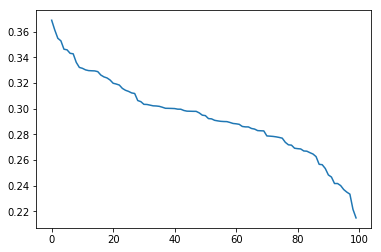

In [248]:
plt.figure()
plot1 = plt.plot(df_error.index.values, df_error["Error"])

## Apresentação da taxa de error no teste

O grafico abaixo mostra a redução da taxa de erro, durante o teste entre os n-folds, ordenada de forma decrescente. 

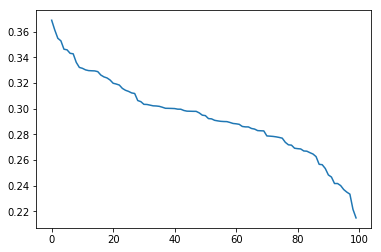

In [249]:
plt.figure()
plot1 = plt.plot(df_error_test.index.values, df_error["Error"])

In [16]:
bestModel = scoresDF.iloc[0, 7]

In [12]:
pred_validation = bestModel.predict(validationData)

In [13]:
printCM(validationLabels, pred_validation)

Confusion Matrix : 
[[11 11]
 [ 5 15]]
Total : 208.0
Acurácia : 0.6190476190476191
Misclassification rate : 0.077
True positives : 0.75
False positives : 0.5
Specificity : 0.5
Precision : 0.6348443223443223
Prevalence : 0.096
Recall : 0.75


(0.6190476190476191, 0.6348443223443223, 0.75)

In [237]:
scoresDF = pd.DataFrame(scores_test, columns=["n-fold", 
                                         "Model Idx",
                                         "Acc", 
                                         "Precision", 
                                         "Recall",
                                         "Error", 
                                         "Alpha", 
                                         "Model"])

scoresDF.sort_values(["Acc","Error"], ascending=False).head(5)

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
92,9,2,0.875000,0.875000,0.909,0.273766,0.487799,"DecisionTreeClassifier(class_weight=None, crit..."
80,8,0,0.875000,0.875000,0.800,0.253333,0.540456,"DecisionTreeClassifier(class_weight=None, crit..."
18,1,8,0.823529,0.831699,0.857,0.297959,0.428518,"DecisionTreeClassifier(class_weight=None, crit..."
47,4,7,0.823529,0.837790,0.800,0.284574,0.460942,"DecisionTreeClassifier(class_weight=None, crit..."
22,2,2,0.823529,0.837790,0.833,0.277014,0.479660,"DecisionTreeClassifier(class_weight=None, crit..."


# Conclusões

Observando através de diversas simulações, podemos ver pelo comportamento do erro de aprendizagem dos modelos na medida que vai sendo minimizado o resultado da acuracia, precisão e recall tende a ambos se equilibrarem